In [1]:
%%capture
%pip install -U git+https://github.com/istat-methodology/semantic-search.git

# CIRCE vs Semantic Search (ATECO 2022 Classification)

In [267]:
import pandas as pd
import numpy as np
import ast
import requests
import time
import json
import matplotlib.pyplot as plt
import plotly.express as px
from collections import Counter
from typing import List
from tqdm import tqdm
from semantic_search.data import build_corpus
from semantic_search.local import LocalKnowledgeBase

## Configs

In [102]:
MODEL_ID      : str  = "BAAI/bge-m3"
EXTRACT_CIRCE : bool = False
SAMPLE_INT    : int  = None

---

## Data
Etract and parse the **ATECO 2022** classification.

In [7]:
ateco22_df = pd.read_csv("data/ateco_2022_raw.csv")
ateco22_df = ateco22_df[ateco22_df["section"].str.len() == 8]

codes = []
texts = []
for i, row in ateco22_df.iterrows():
    if row["title"]:
        codes.append(row["section"])
        texts.append(row["title"].lower())

    if type(row["description"]) == str:
        desc = row["description"]
        desc = desc.split(". Sono escluse")[0]
        desc_list = desc.split(" - ")

        for d in desc_list:
            codes.append(row["section"])
            texts.append(d.lower().strip("- "))

Now exract and parse the **unlabeled sample queries**.

In [8]:
df = pd.read_csv("data/ateco_sample_queries.csv", sep=";")

if SAMPLE_INT:
    sampled_df = df.sample(SAMPLE_INT, random_state=42)

else:
    sampled_df = df.copy()

sampled_df.drop(columns=["ID"], inplace=True)
sampled_df.rename(columns={"Stringa": "query"}, inplace=True)

queries = sampled_df["query"].tolist()

---

## ATECO Classification

### CIRCE Classification
Import the **CIRCE labeled data**, or scrape it setting `EXTRACT_CIRCE` equal to `True`.

In [11]:
if EXTRACT_CIRCE:
    url = "https://www.istat.it/wp-content/themes/EGPbs5-child/ateco/atecor.php"
    headers = {"Content-Type": "application/x-www-form-urlencoded"}

    with open("data/circe_results.json", "w") as f:
        json.dump({}, f)

    results_dict = {}
    for idx, query in tqdm(enumerate(queries), total=len(queries)):
        results_dict[idx] = {}
        results_dict[idx]["query"] = query
        data = {"search": query}
        try:
            response = requests.post(url, data=data, headers=headers)
            response_dict = ast.literal_eval(response.text.replace('""', '"'))

            results_dict[idx]["result"] = {}

            for j, res in enumerate(response_dict["0"]):
                results_dict[idx]["result"][j] = {}
                code = res["ateco_code"]
                desc = res["ateco_description"]
                results_dict[idx]["result"][j]["code"] = code
                results_dict[idx]["result"][j]["desc"] = desc

        except:
            results_dict[idx]["result"] = "ERROR"
            print(f"ERROR: {idx}")

        with open("data/circe_results.json", "r") as f:
            json_data = json.load(f)
        json_data.update(results_dict)
        with open("data/circe_results.json", "w") as f:
            json.dump(json_data, f)

        time.sleep(0.005)

else:
    with open("data/circe_results.json", "r") as f:
        results_dict = json.load(f)

### Semantic Search
First, we need to define a utility functions to parse the retrieved results.

In [26]:
def parse_retrieved(results):
    codes = [r.metadata["code"] for r in results]
    texts = [r.metadata["source_text"] for r in results]
    scores = [r.score for r in results]

    df = pd.DataFrame({
        "code": codes,
        "matched_text": texts,
        "score": scores
    })

    grouped_df = df.groupby("code").aggregate({
        "score": "max",
    }).reset_index()

    return grouped_df.sort_values("score", ascending=False)

Now we can build the corpus and the knowledge base.

In [ ]:
corpus = build_corpus(
    texts=texts,
    ids=list(range(len(texts))),
    metadata=[{"code": c} for c in codes]
)

base = LocalKnowledgeBase(
    corpus=corpus,
    model_id=MODEL_ID,
    batch_size=16
)

Then, we can extract the results for each of the sample queries.

In [ ]:
results = base.search(queries, top_k=30)

### CIRCE vs Semantic
Finally, we can compare the results from both approaches and measure their overlap.

In [184]:
top_k = 10

top_results = []
circe_guess = []
sem_search_guess = []

for idx, res in enumerate(results):
    try:
        circe = results_dict[str(idx)]["result"]
        if circe == "ERROR" or "n.c" in circe["0"]["code"]:
            continue
        ateco_circe = set(np.unique([circe[key]["code"] for key in circe.keys()]).tolist())

        sem_search_res = parse_retrieved(res.results).iloc[:top_k]["code"].tolist()
        sem_search_res = set([r[:-1] for r in sem_search_res])

        if ateco_circe.intersection(sem_search_res):
            top_results.append(1)
        else:
            top_results.append(0)

        circe_guess.append(list(ateco_circe))
        sem_search_guess.append(list(sem_search_res))

    except:
        pass

Extract the average overlap.

In [185]:
average_overlap = np.mean(top_results)

print(f"Average overlap (Top {top_k}): {average_overlap:.3f}")

Average overlap (Top 10): 0.724


Define a function to extract the overlap at different hierarchy levels.

In [186]:
def average_overlap(circe_guess, sem_search_guess, level: str = None):
    level_map = {
        "divisione": 2,
        "gruppo": 4,
        "classe": 5,
        "categoria": 7,
        "sottocategoria": 8
    }
    assert level in level_map.keys() or level is None, "Invalid level"

    level_int = level_map[level] if level else 8

    overlap_int = []
    for guess_c, guess_s in zip(circe_guess, sem_search_guess):
        set_c = set([i[:level_int] for i in guess_c])
        set_s = set([i[:level_int] for i in guess_s])

        overlap_int.append(1 if set_c.intersection(set_s) else 0)

    return {"average_overlap": np.mean(overlap_int), "overlap": overlap_int}

Compute the overlap at different hierarchy levels.

In [187]:
levels = ["divisione", "gruppo", "classe", "categoria"]

print(f"CIRCE vs Semantic Search ({MODEL_ID} | Top {top_k})")
print("-"*47)
for level in levels:
    res = average_overlap(circe_guess, sem_search_guess, level=level)
    print(f"Average overlap ({level}): {res['average_overlap']:.3f}")
print("-"*47)

CIRCE vs Semantic Search (BAAI/bge-m3 | Top 10)
-----------------------------------------------
Average overlap (divisione): 0.859
Average overlap (gruppo): 0.805
Average overlap (classe): 0.753
Average overlap (categoria): 0.724
-----------------------------------------------


### Frequency Analysis
First, let's visualize the distribution of labels across CIRCE-assigned divisions.

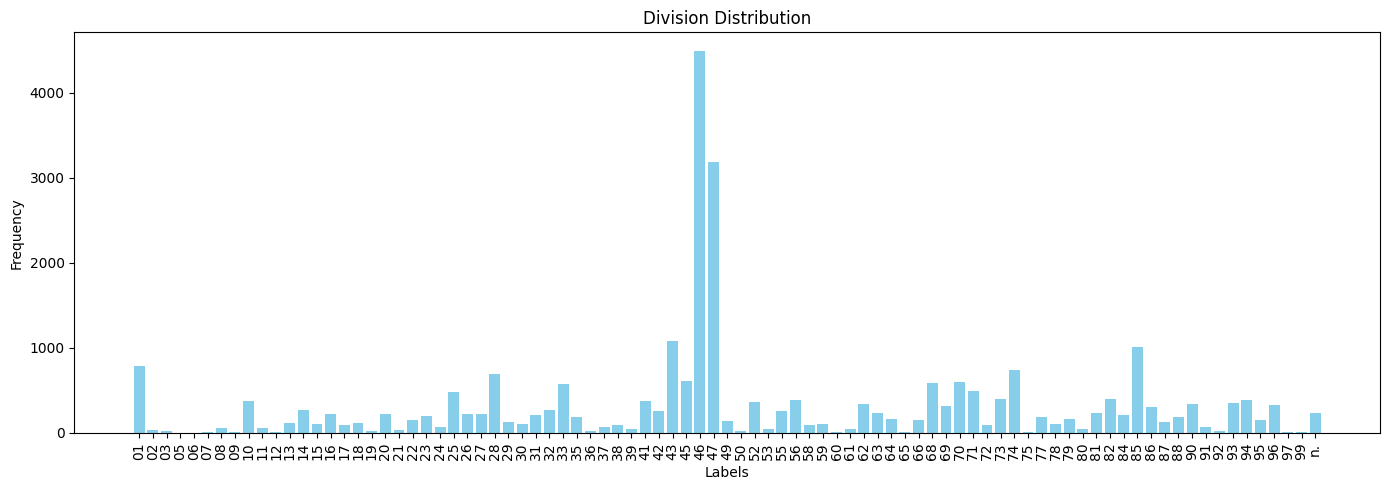

In [190]:
divisions = [[i[:2] for i in r] for r in circe_guess]
flat_divisions = [item for sublist in divisions for item in sublist]

label_counts = dict(sorted(Counter(flat_divisions).items()))

plt.figure(figsize=(14, 5))
plt.bar(label_counts.keys(), label_counts.values(), color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Division Distribution')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Mismatch Analysis
Now, let's visualize the **mismatch** between the CIRCE assigned labels and the semantic search labels **across divisions**.

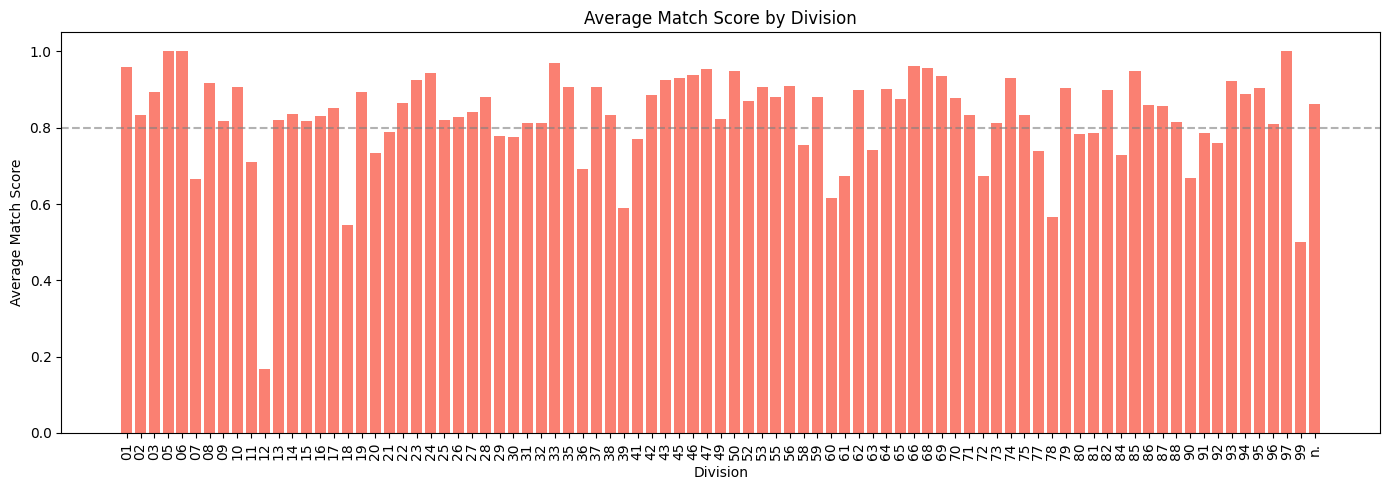

In [225]:
ONLY_INDIVIDUAL  : bool = False
ORDER_BY_DIVISION: bool = True

mismatch_df = pd.DataFrame(columns=["division", "is_match"])

division_overlap = average_overlap(
    circe_guess, sem_search_guess, level="divisione"
)["overlap"]

flat_overalp = []
flat_circe = []
for o, c in zip(division_overlap, circe_guess):
    if ONLY_INDIVIDUAL:
        if len(c) == 1:
            flat_overalp.append(o)
            flat_circe.append(c[0])
    else:
        flat_overalp.extend([o]*len(c))
        flat_circe.extend(c)

mismatch_df["division"] = flat_circe
mismatch_df["division"] = mismatch_df["division"].apply(lambda x: x[:2])
mismatch_df["is_match"] = flat_overalp

mismatch_df = mismatch_df.groupby("division").mean().reset_index()

if ORDER_BY_DIVISION:
    mismatch_df.sort_values("division", inplace=True)
else:
    mismatch_df.sort_values("is_match", ascending=True, inplace=True)

plt.figure(figsize=(14, 5))
plt.bar(mismatch_df["division"], mismatch_df["is_match"], color="salmon")

plt.xlabel("Division")
plt.ylabel("Average Match Score")
plt.title("Average Match Score by Division")
plt.xticks(rotation=90)
plt.axhline(y=0.8, color='grey', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Finally, we can plot the overlap by hierarchy interactively.

In [283]:
def rectangular_circe(flat_circe_guess, flat_overlap):
    divisione = [c[:2] for c in flat_circe]
    gruppo = [c[:4] for c in flat_circe]
    classe = [c[:5] for c in flat_circe]
    categoria = [c[:7] for c in flat_circe]

    df = pd.DataFrame({
        "divisione": divisione,
        "gruppo": gruppo,
        "classe": classe,
        "categoria": categoria,
        "is_match": flat_overlap,
        "count": [1]*len(flat_overlap)
    })

    df = df.groupby(["divisione", "gruppo", "classe", "categoria"]).aggregate({
        "is_match": "mean",
        "count": "sum"
    }).reset_index()

    return df

circe_rect = rectangular_circe(flat_circe, flat_overalp)

fig = px.treemap(
    circe_rect,
    path=['divisione', 'gruppo', 'classe'],
    values='count',
    color='is_match',
    color_continuous_scale='RdBu',
    range_color=[0, 1],
    maxdepth=2,
    color_continuous_midpoint=circe_rect['is_match'].mean()
)

fig.update_traces(
    hovertemplate='<b>%{label}</b><br>Count: %{value}<br>Avg score: %{color:.2f}'
)
fig.update_layout(margin=dict(t=40, l=25, r=25, b=25), title='Average Overlap by Hierarchical Level')

fig.show()

---

## Ground Truth
Here, we assume that the ground truth can be considered as **CIRCE classifications with only one results**.

In [ ]:
training_set_circe = pd.DataFrame(columns=["query", "label", "description"])


circe_guess_individual = []
queries_individual = []
descriptions_individual = []

for k in results_dict.keys():
    results = results_dict[k]["result"]

    if results == "ERROR":
        continue

    guess = [r[1]["code"] for r in results.items()]

    if len(guess) == 1 and "n.c." not in guess[0]:
        circe_guess_individual.append(guess[0])
        queries_individual.append(results_dict[k]["query"])
        descriptions_individual.append(results_dict[k]["result"]["0"]["desc"])

training_set_circe["query"] = queries_individual
training_set_circe["label"] = circe_guess_individual
training_set_circe["description"] = descriptions_individual

training_set_circe.head()

Export the training set.

In [99]:
training_set_circe.to_csv("data/ground_truth_circe.csv", index=False)